In [1]:
from sklearn.base import BaseEstimator, RegressorMixin

class KRR(BaseEstimator, RegressorMixin):

    def __init__(self, kernel_func , sigma=None, lamb=None):

        """
        User must provide a kernelfunction, 
        sigma and lambda are optinal for initialization
        """

        self.kernel_func  = kernel_func
        self.sigma        = sigma or 1
        self.lamb         = lamb  or 1e-7
        
        
        """
        get_params and set_params are used by sklearn e.g. for hyperparameter
        optimization
        """

    def get_params(self, deep=True):

        return {"sigma": self.sigma, "lamb": self.lamb, "kernel_func":self.kernel_func}

    def set_params(self, **parameters):

        self.sigma        = parameters["sigma"]
        self.lamb         = parameters["lamb"]      
        self.kernel_func  = parameters["kernel_func"]
        
        return self
    
    def fit(self, X, y):

        Kernel_train  = self.kernel_func(X,X, self.sigma)
    

        for i in range(Kernel_train.shape[0]):
            Kernel_train[i, i] -= self.lamb
   
        self.ALPHA_SOL = np.linalg.solve(Kernel_train, y)
        self.XTRAIN    = X
        
        return self
    
    def predict(self, Xqry):

        Kernel_test     = self.kernel_func(self.XTRAIN, Xqry, self.sigma)
        print(Kernel_test.shape)
        print(self.ALPHA_SOL.shape)
        pred            = np.dot(self.ALPHA_SOL, Kernel_test) #np.dot(self.ALPHA_SOL, Kernel_test)
        return pred
    
    def kpca(self, X):
        Kernel_train  = self.kernel_func(X,X, self.sigma)

        from sklearn.decomposition import PCA

        pca     = PCA(n_components=2)
        kpca    = pca.fit_transform(Kernel_train)

        return kpca

1 d funktion **Example**

In [47]:
import numpy as np
import numpy.linalg as LA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def simple_distance(xa, xb):
    if len(xa.shape) == 1:
        measure = abs
    else:
        measure = LA.norm


    d = np.zeros((len(xa),len(xb) ))
    for i,x1 in enumerate(xa):
        for j,x2 in enumerate(xb):
            d[i][j]  = measure(x1 - x2) 

    return d    

def kernel_1d_fct(Xa, Xb, sigma):
    dist = simple_distance(Xa, Xb)
    
    return np.exp(-sigma* dist)
    

X = np.linspace(1, 20, 20)
y = np.exp(-X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,shuffle=True, random_state=663)

regressor = KRR(kernel_1d_fct, 1, 1e-8)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

(10, 10)
(10,)


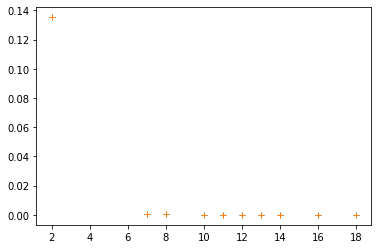

In [48]:
plt.plot( X_test, y_test, "+")
plt.plot( X_test, y_pred, "+")

KRR(kernel_func=<function kernel_1d_fct at 0x7f18e3093510>, lamb=1e-08, sigma=1)

In [22]:
len(X_train.shape)

1

(33, 17)
(33, 1)


ValueError: shapes (33,1) and (33,17) not aligned: 1 (dim 1) != 33 (dim 0)

In [83]:
regressor.ALPHA_SOL

AttributeError: 'KRR' object has no attribute 'ALPHA_SOL'

In [43]:
X.shape

(50,)

In [45]:
X_train.shape

(33,)

In [59]:
X.reshape(-1,1).shape

(50, 1)